In [14]:
import numpy as np
import json
import torch
import torch.nn as nn
from networks import SCLIPNN
import clip
from PIL import Image
from sentence_transformers import SentenceTransformer
import torchvision.transforms.functional as fn
import pandas as pd
import yaml
import os
from datetime import datetime
import matplotlib.pyplot as plt
from experiment import *

## Define Functions

In [15]:
def run_experiment(name_of_model, dataset):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    with open(os.path.join("preprocessing", "config.yml"), "r") as ymlfile:
        cfg = yaml.safe_load(ymlfile)
    directory = cfg[dataset]["out_dir"]
    image_directory = cfg[dataset]["image_dir"]
    languages = cfg["languages"]
    model_dir = cfg["models"]["model_dir"]
    trained_model = os.path.join(model_dir,name_of_model)
    sbert_model, clip_model, preprocess = get_sbert_and_clip_models()
    images, captions = get_images_and_captions(directory, languages)
    images_features = get_image_features(images["english"], image_directory, clip_model, preprocess)
    model = load_model(trained_model,sbert_model)
    sbert_per, clip_per, sbert_MRR, clip_MRR, sbert_errors, sbert_acc, clip_acc, clip_errors = get_MRR(languages,model,name_of_model,sbert_model,clip_model,captions, images_features)
    return sbert_per, clip_per, sbert_MRR, clip_MRR, sbert_errors, sbert_acc, clip_acc, clip_errors

In [30]:
def plot_metric(sbert_values, clip_values, name_of_metric):
    X_axis = np.arange(len(languages.keys()))
    figure_name = plt.figure(figsize=(20, 8))
    plt.bar(X_axis-0.2, sbert_values, 0.4, color = 'blue', edgecolor = 'black', capsize=7, label='SCLIP '+name_of_metric)
    plt.bar(X_axis+0.2, clip_values, 0.4, color = 'red', edgecolor = 'black', capsize=7, label='CLIP '+name_of_metric)
    plt.xticks(rotation = 45)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.xticks(X_axis, languages.keys())
    plt.legend(fontsize=15)
    plt.grid()
    plt.show()

## Model Coco, Dataset Crossmodal

In [12]:
sbert_per,clip_per, sbert_MRR,clip_MRR, sbert_errors, clip_errors, sbert_acc, clip_acc  = run_experiment('coco_NN_1000_e300_s400000.pt',"crossmodal")
results = get_results(sbert_per,clip_per, sbert_MRR,clip_MRR, sbert_errors, clip_errors, sbert_acc, clip_acc) 

SBERT model loaded
CLIP model loaded
Lang english. Timestamp: 2023-04-27 17:43:05.299311
Lang spanish. Timestamp: 2023-04-27 17:43:06.073830
Lang italian. Timestamp: 2023-04-27 17:43:06.848359
Lang german. Timestamp: 2023-04-27 17:43:07.657476
Lang french. Timestamp: 2023-04-27 17:43:08.468557
Lang polish. Timestamp: 2023-04-27 17:43:09.240975
[CLIP] Not able to tokenize in polish. Skipping language pl


In [13]:
results

,SBERT,CLIP,MRR sbert,MRR clip,Error SBERT,Error CLIP,Accuracy SBERT,Accuracy CLIP
english,0.0072,0.0168,0.557,0.809,0.582,0.286,0.418,0.714
spanish,0.0071,0.0079,0.519,0.581,0.616,0.544,0.384,0.456
italian,0.0074,0.0054,0.508,0.438,0.644,0.670,0.356,0.330
german,0.0078,0.0055,0.558,0.439,0.580,0.680,0.420,0.320
french,0.0078,0.0081,0.611,0.608,0.524,0.512,0.476,0.488
polish,0.0060,0.0081,0.464,0.608,0.658,0.512,0.342,0.488


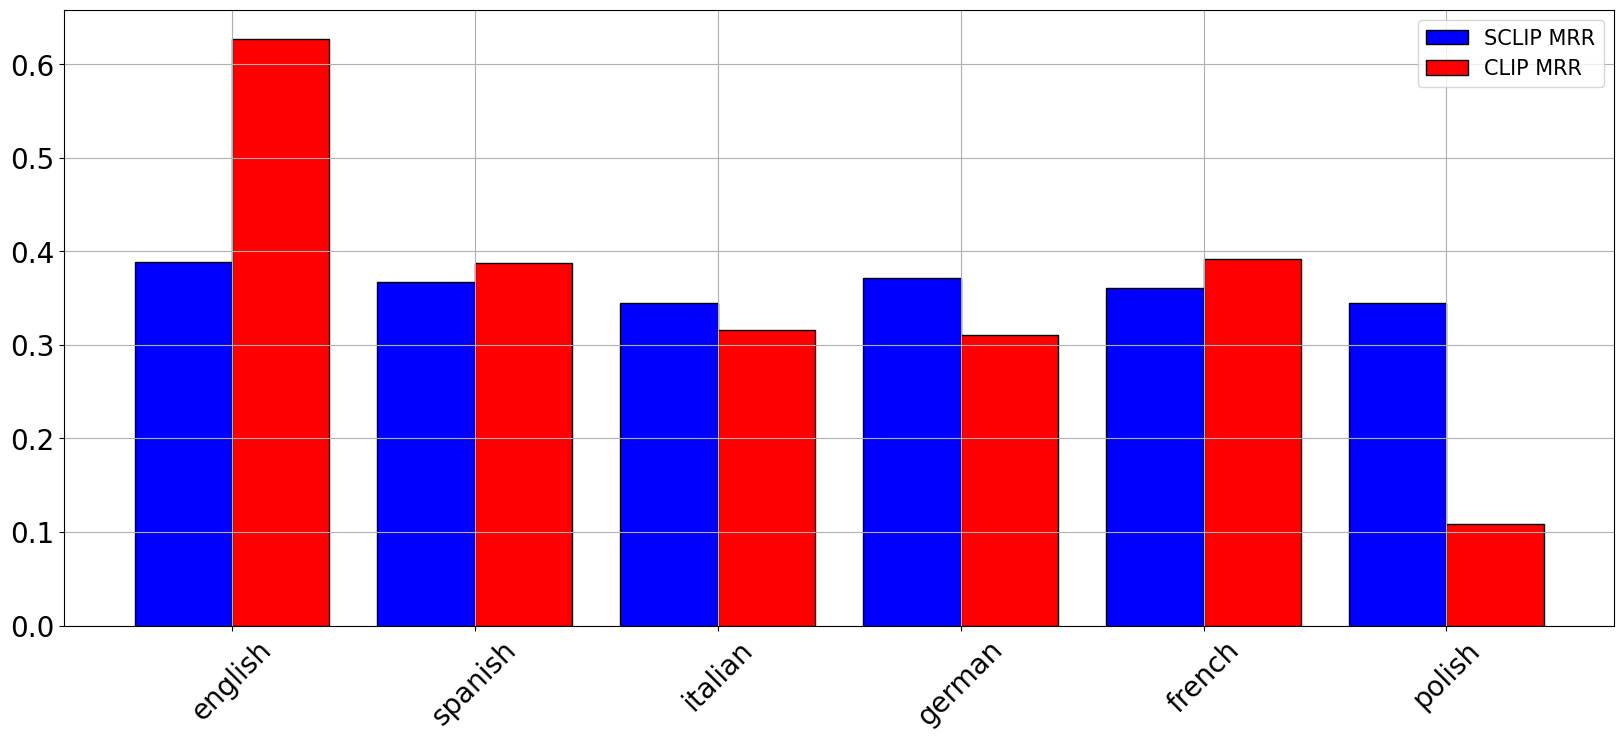

In [31]:
plot_metric(sbert_MRR, clip_MRR, "MRR")

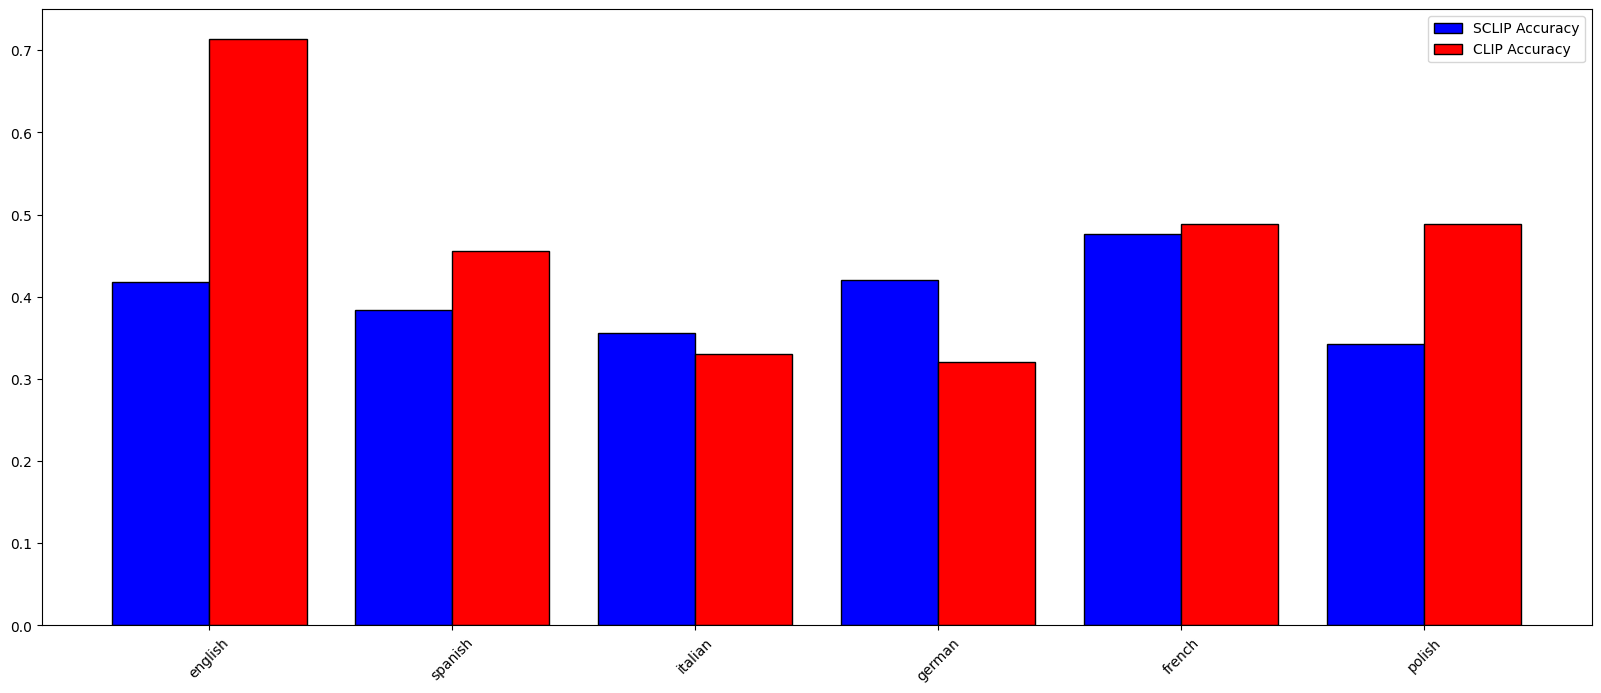

In [16]:
plot_metric(sbert_acc, clip_acc, "Accuracy")

## Model Coco, Dataset Coco

In [35]:
sbert_per,clip_per, sbert_MRR,clip_MRR, sbert_errors, clip_errors, sbert_acc, clip_acc  = run_experiment('coco_NN_1000_e300_s400000.pt',"coco")
results = get_results(sbert_per,clip_per, sbert_MRR,clip_MRR, sbert_errors, clip_errors, sbert_acc, clip_acc) 

SBERT model loaded
CLIP model loaded
Lang english. Timestamp: 2023-04-28 09:07:02.420795
Lang spanish. Timestamp: 2023-04-28 09:07:03.067654
Lang italian. Timestamp: 2023-04-28 09:07:03.868183
Lang german. Timestamp: 2023-04-28 09:07:04.566134
Lang french. Timestamp: 2023-04-28 09:07:05.223137
Lang polish. Timestamp: 2023-04-28 09:07:05.864511


In [36]:
results

,SBERT,CLIP,MRR sbert,MRR clip,Error SBERT,Error CLIP,Accuracy SBERT,Accuracy CLIP
english,0.0110,0.0155,0.525,0.627,0.602222,0.484444,0.397778,0.515556
spanish,0.0102,0.0066,0.503,0.387,0.628889,0.740000,0.371111,0.260000
italian,0.0098,0.0057,0.470,0.316,0.662222,0.795556,0.337778,0.204444
german,0.0103,0.0056,0.478,0.311,0.660000,0.804444,0.340000,0.195556
french,0.0103,0.0071,0.476,0.392,0.660000,0.722222,0.340000,0.277778
polish,0.0089,0.0029,0.445,0.109,0.684444,0.942222,0.315556,0.057778


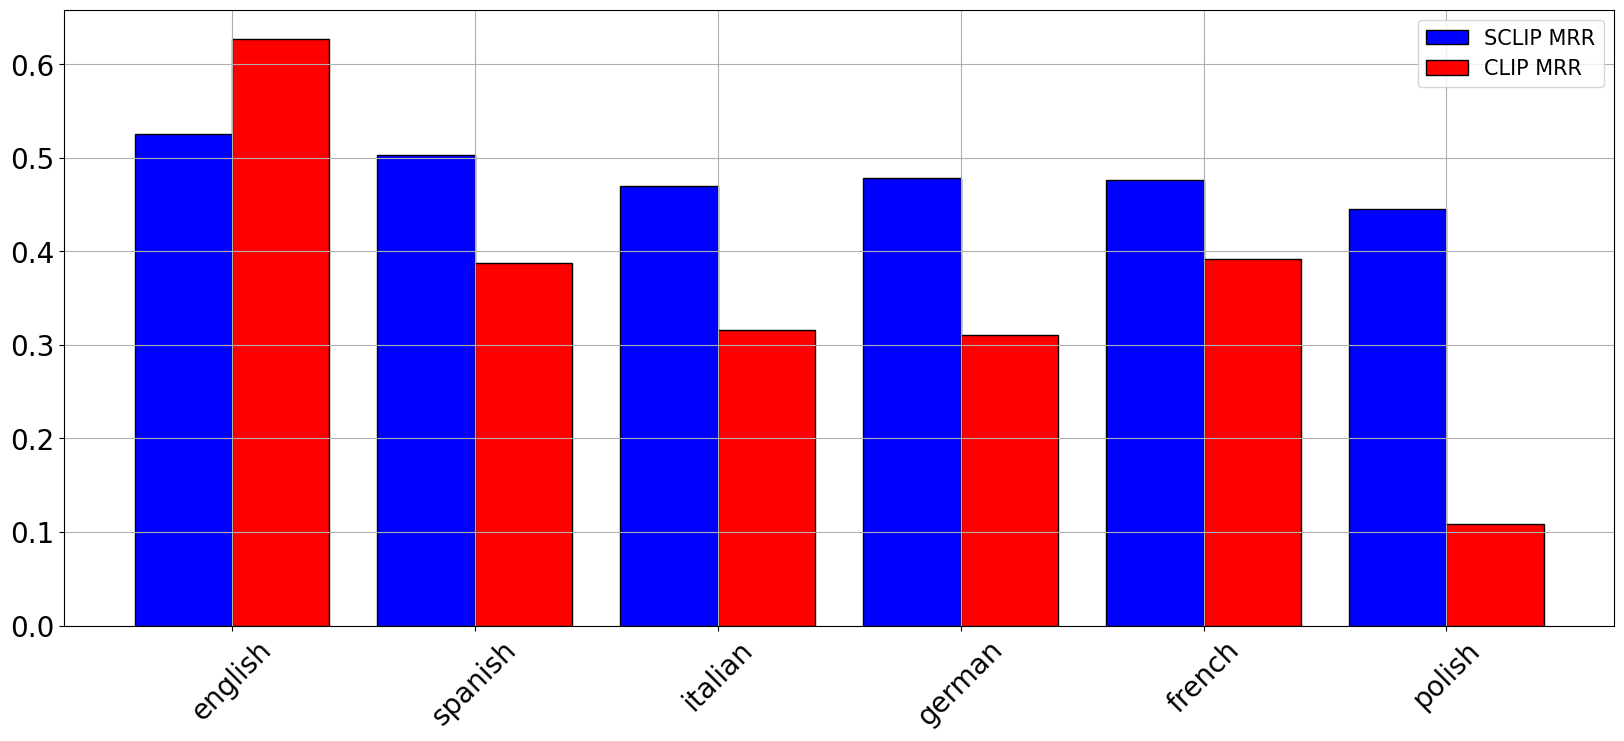

In [38]:
plot_metric(sbert_MRR, clip_MRR, "MRR")

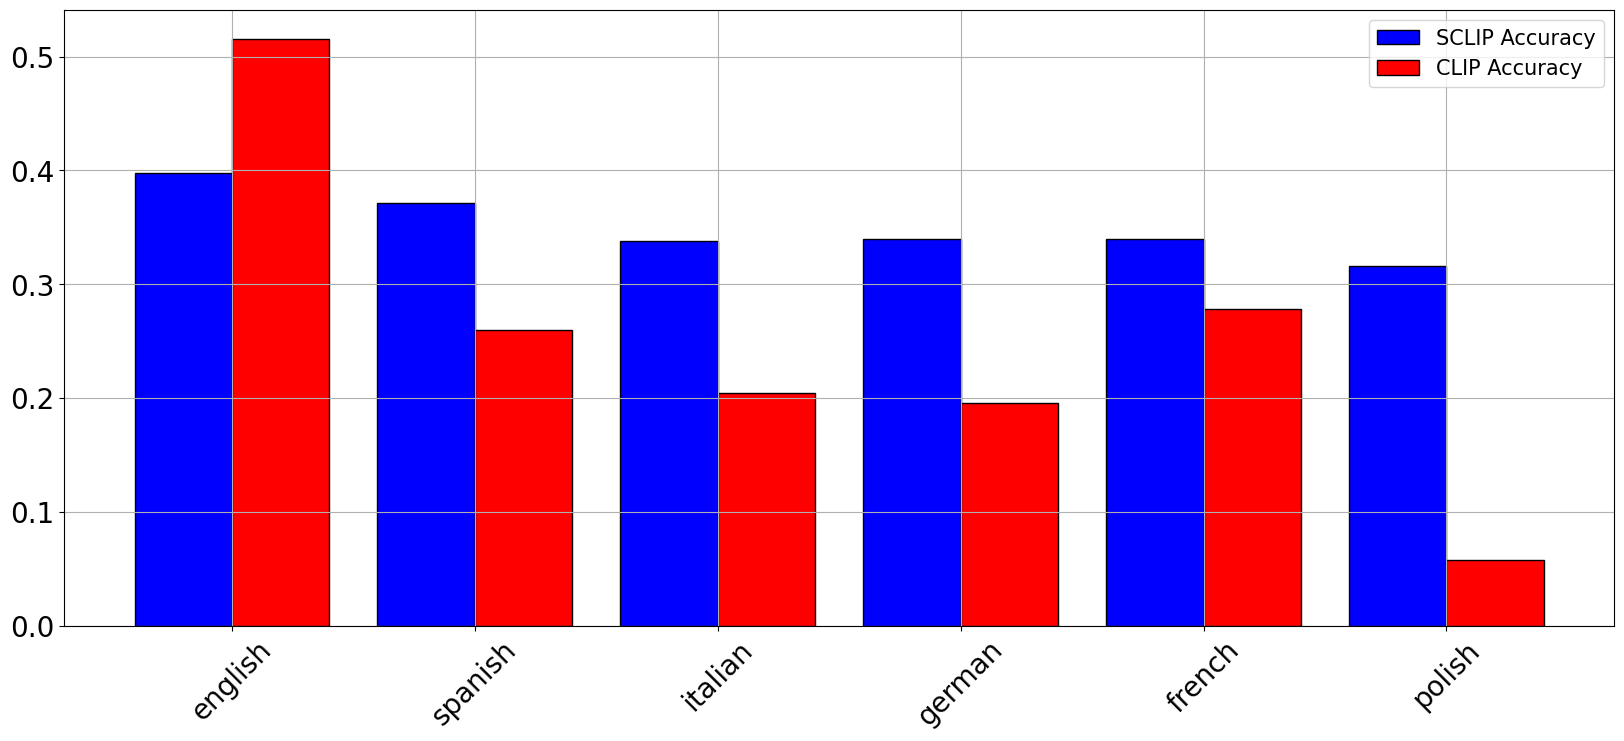

In [39]:
plot_metric(sbert_acc, clip_acc, "Accuracy")

## Model GCO, Dataset Crosmodal

In [5]:
sbert_per,clip_per, sbert_MRR,clip_MRR, sbert_errors, clip_errors, sbert_acc, clip_acc  = run_experiment('gco_NN3_1000_e300_s3127982.pt',"crossmodal")
results = get_results(sbert_per,clip_per, sbert_MRR,clip_MRR, sbert_errors, clip_errors, sbert_acc, clip_acc) 

SBERT model loaded
CLIP model loaded
models/gco_NN3_1000_e300_s3127982.pt
Lang english. Timestamp: 2023-04-27 18:10:38.042085
Lang spanish. Timestamp: 2023-04-27 18:10:38.830302
Lang italian. Timestamp: 2023-04-27 18:10:39.568874
Lang german. Timestamp: 2023-04-27 18:10:40.407839
Lang french. Timestamp: 2023-04-27 18:10:41.221883
Lang polish. Timestamp: 2023-04-27 18:10:42.082893
[CLIP] Not able to tokenize in polish. Skipping language pl


In [7]:
results

,SBERT,CLIP,MRR sbert,MRR clip,Error SBERT,Error CLIP,Accuracy SBERT,Accuracy CLIP
english,0.0051,0.0168,0.426,0.809,0.720,0.286,0.280,0.714
spanish,0.0052,0.0079,0.387,0.581,0.758,0.544,0.242,0.456
italian,0.0053,0.0054,0.393,0.438,0.734,0.670,0.266,0.330
german,0.0055,0.0055,0.409,0.439,0.732,0.680,0.268,0.320
french,0.0055,0.0081,0.445,0.608,0.692,0.512,0.308,0.488
polish,0.0045,0.0081,0.370,0.608,0.748,0.512,0.252,0.488


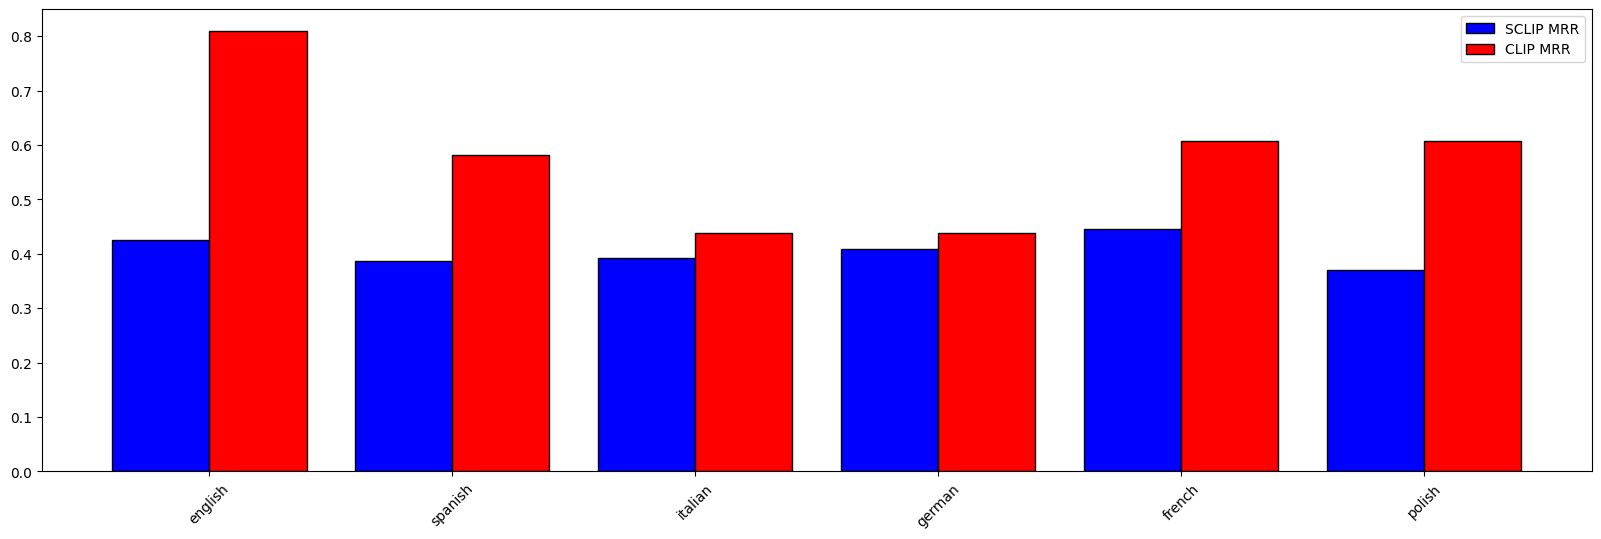

In [8]:
plot_metric(sbert_MRR, clip_MRR, "MRR")

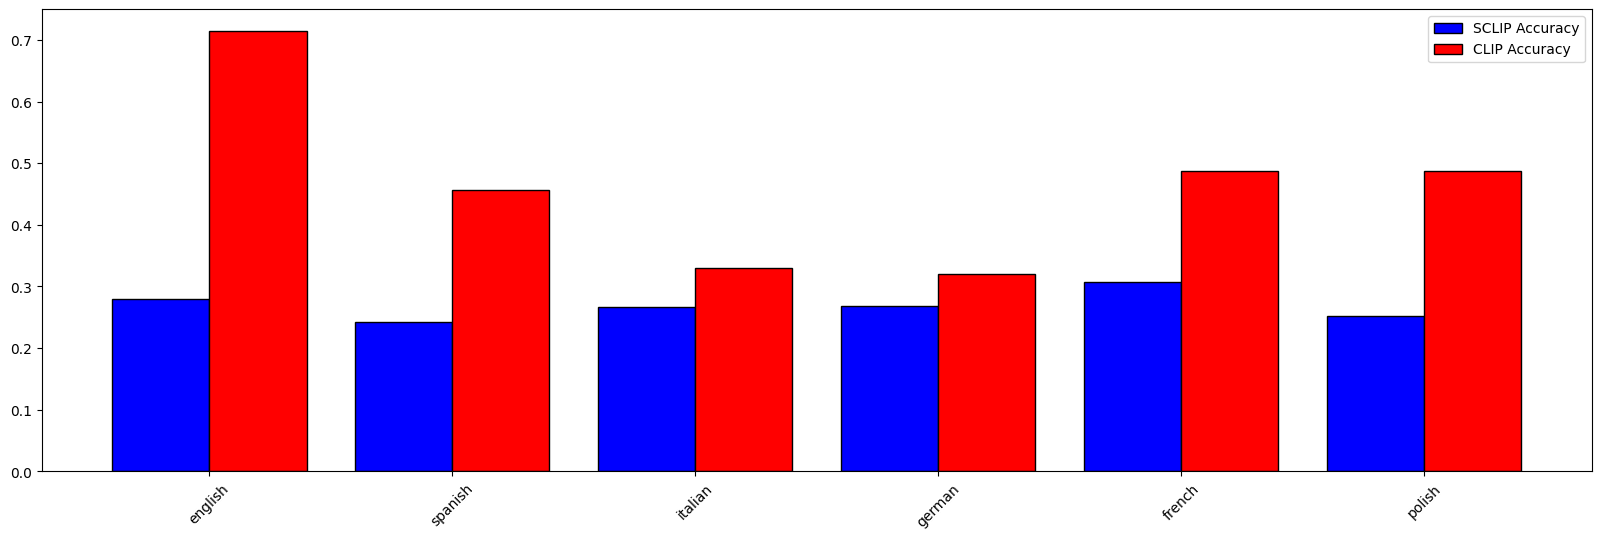

In [9]:
plot_metric(sbert_acc, clip_acc, "Accuracy")

In [10]:
sbert_per,clip_per, sbert_MRR,clip_MRR, sbert_errors, clip_errors, sbert_acc, clip_acc  = run_experiment('gco_NN3_1000_e300_s3127982.pt',"coco")
results = get_results(sbert_per,clip_per, sbert_MRR,clip_MRR, sbert_errors, clip_errors, sbert_acc, clip_acc) 

SBERT model loaded
CLIP model loaded
models/gco_NN3_1000_e300_s3127982.pt
Lang english. Timestamp: 2023-04-27 18:12:26.516819
Lang spanish. Timestamp: 2023-04-27 18:12:27.219778
Lang italian. Timestamp: 2023-04-27 18:12:27.898978
Lang german. Timestamp: 2023-04-27 18:12:28.607334
Lang french. Timestamp: 2023-04-27 18:12:29.308815
Lang polish. Timestamp: 2023-04-27 18:12:30.087102


In [11]:
results

,SBERT,CLIP,MRR sbert,MRR clip,Error SBERT,Error CLIP,Accuracy SBERT,Accuracy CLIP
english,0.0063,0.0155,0.389,0.627,0.740000,0.484444,0.260000,0.515556
spanish,0.0061,0.0066,0.367,0.387,0.764444,0.740000,0.235556,0.260000
italian,0.0059,0.0057,0.345,0.316,0.782222,0.795556,0.217778,0.204444
german,0.0062,0.0056,0.371,0.311,0.748889,0.804444,0.251111,0.195556
french,0.0063,0.0071,0.361,0.392,0.771111,0.722222,0.228889,0.277778
polish,0.0056,0.0029,0.345,0.109,0.768889,0.942222,0.231111,0.057778


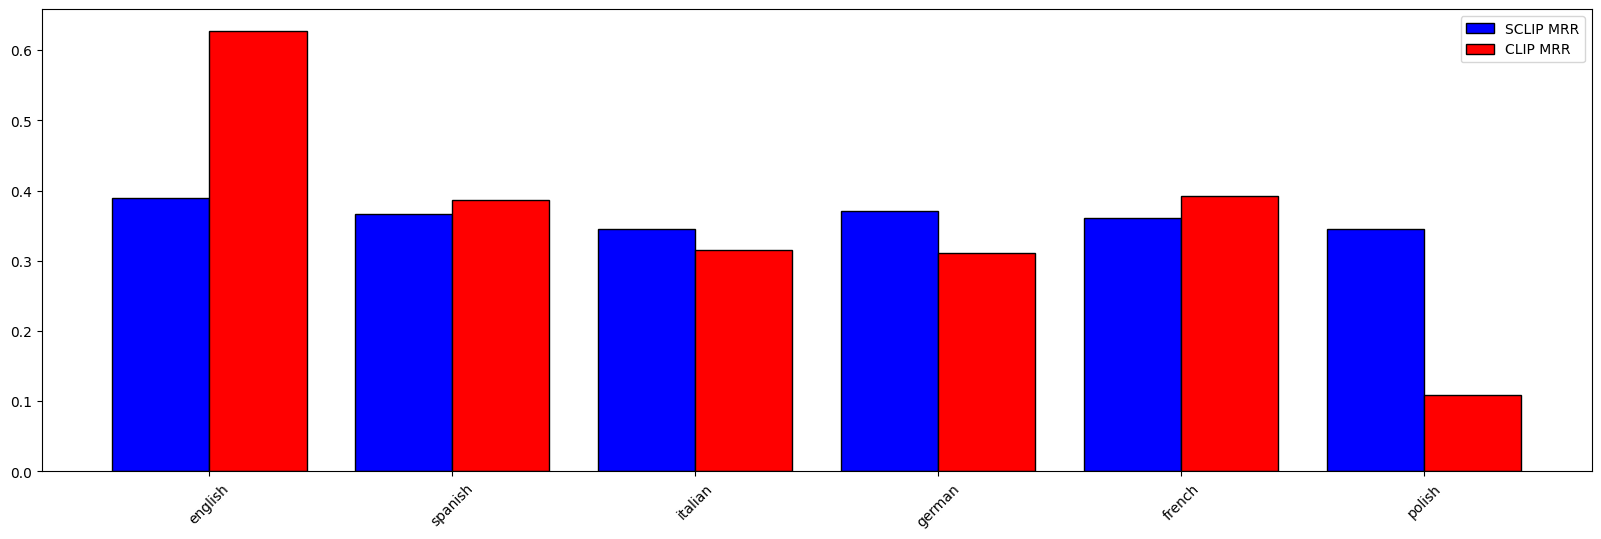

In [12]:
plot_metric(sbert_MRR, clip_MRR, "MRR")

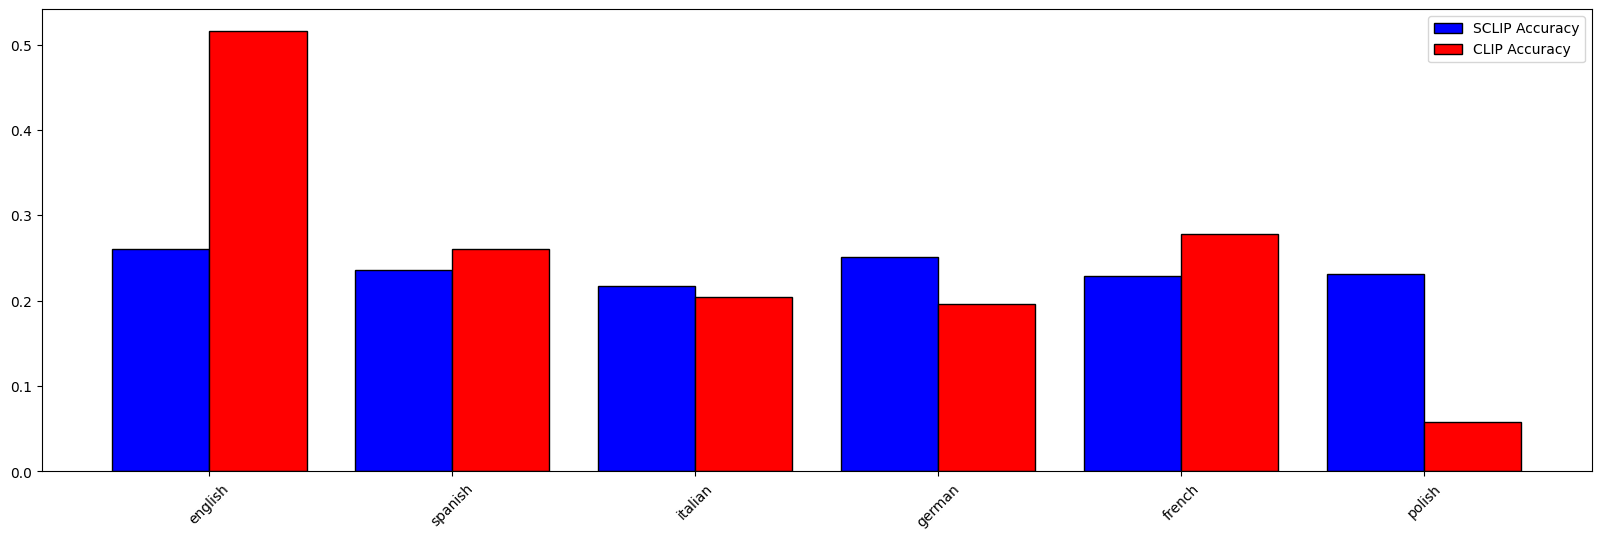

In [13]:
plot_metric(sbert_acc, clip_acc, "Accuracy")

## Final Metrics

In [40]:
models = ['coco_NN_1000_e300_s400000.pt', 'gcc_NN_750_e300_s2654581.pt', 'gco_NN3_1000_e300_s3127982.pt']
clip_MRR = []
sbert_MRR = []
for model in models:
    sbert_per,clip_per, sbert_MRR,clip_MRR, sbert_errors, clip_errors, sbert_acc, clip_acc  = run_experiment(model,"coco")
    results = get_results(sbert_per,clip_per, sbert_MRR,clip_MRR, sbert_errors, clip_errors, sbert_acc, clip_acc) 
    clip_MRR.append(clip_MRR)
    sbert_MRR.append(sbert_MRR)

SBERT model loaded
CLIP model loaded
Lang english. Timestamp: 2023-04-28 09:25:32.661110
Lang spanish. Timestamp: 2023-04-28 09:25:33.280283
Lang italian. Timestamp: 2023-04-28 09:25:33.964540
Lang german. Timestamp: 2023-04-28 09:25:34.579896
Lang french. Timestamp: 2023-04-28 09:25:35.261381
Lang polish. Timestamp: 2023-04-28 09:25:35.890989
SBERT model loaded
CLIP model loaded


RuntimeError: Error(s) in loading state_dict for SCLIPNN:
	size mismatch for linear1.weight: copying a param with shape torch.Size([750, 512]) from checkpoint, the shape in current model is torch.Size([1000, 512]).
	size mismatch for linear1.bias: copying a param with shape torch.Size([750]) from checkpoint, the shape in current model is torch.Size([1000]).
	size mismatch for linear2.weight: copying a param with shape torch.Size([512, 750]) from checkpoint, the shape in current model is torch.Size([512, 1000]).